# Introduction

TODO


# Imports

In [1]:
from __future__ import print_function
import tensorflow as tf
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, GRU, Dot, TimeDistributed, Activation, Embedding, Lambda, Concatenate, Reshape
from keras import optimizers
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import json
from keras.models import load_model
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize, sent_tokenize
import pandas as pd
import re
%matplotlib inline

Using TensorFlow backend.


# Utility functions

In [2]:
def gpu_alloc(device_id):
    os.environ["CUDA_VISIBLE_DEVICES"]=device_id
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))

In [3]:
gpu_alloc("1")

In [4]:
def build_chars_vocab(all_texts):
    '''Build vocab dictionary to victorize chars into ints'''
    vocab_to_int = {}
    count = 0 # Start index for any char will be 1, as 0 is masked by the Embedding/Masking layer
    codes = ['UNK', ' ', '\t','\n']# Start 'UNK' at the first entry, to keep its index=0 to be masked
    for code in codes:
        if code not in vocab_to_int:
            vocab_to_int[code] = count
            count += 1    
    
    for sentence in all_texts:
        for char in sentence:
            if char not in vocab_to_int:
                vocab_to_int[char] = count
                count += 1


    '''''Build inverse translation from int to char'''
    int_to_vocab = {}
    for character, value in vocab_to_int.items():
        int_to_vocab[value] = character
        
    return vocab_to_int, int_to_vocab

In [5]:
def vectorize_sentences_data(input_texts, target_labels, max_sents_per_doc, max_words_per_sent, max_chars_per_word, 
                             num_classes, char2int):

    
    
    hier_input_data = np.zeros((len(input_texts), 
                                max_sents_per_doc, 
                                max_words_per_sent, 
                                max_chars_per_word), dtype='float32')
    
        
    hier_target_data = np.zeros((len(input_texts), num_classes), dtype='float32')
    if(target_labels == None):
        target_labels = np.zeros(len(input_texts), dtype='int32')
    
    for i, (input_text, target_label) in enumerate(zip(input_texts, target_labels)):
        #sents_lst = sent_tokenize(clean_str(BeautifulSoup(input_text).get_text())) # TODO: Move to clean str
        sents_lst = sent_tokenize(input_text)
        
        
        if len(sents_lst) > max_sents_per_doc:
            continue
        
        for j, sent in enumerate(sents_lst):
                
            words_lst = word_tokenize(input_text)
            
            if(len(words_lst) > max_words_per_sent):
                continue
            
            
            for k, word in enumerate(words_lst):
                
                
                if(len(word) > max_chars_per_word):
                    continue
                
                for l, char in enumerate(word):
                    # c0..cn
                    if(char in char2int):
                        hier_input_data[i, j, k, l] = char2int[char]
                        try:
                            hier_target_data[i, target_label] = 1
                        except:
                            print(target_label)

                
    return hier_input_data, hier_target_data

In [6]:
def build_chars2word_model_simple_BiLSTM(num_encoder_tokens, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None,), dtype='float32')
    #print('encoder_inputs' + str(encoder_inputs.shape))
    encoder_inputs_ = Embedding(num_encoder_tokens, num_encoder_tokens,                           
                            weights=[np.eye(num_encoder_tokens)],
                            mask_zero=True, trainable=False)(encoder_inputs)    
    #encoder_inputs = Input(shape=(None, num_encoder_tokens))
    #encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder = Bidirectional(LSTM(latent_dim)) # Bi LSTM
    #print('encoder_inputs_' + str(encoder_inputs_.shape))
    #encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
    encoder_outputs = encoder(encoder_inputs_)# Bi LSTM
    #print('encoder_outputs' + str(encoder_outputs.shape))
    #encoder_embedding_output = Lambda(lambda x: x[:,-1,:])(encoder_outputs)
    encoder_embedding_output = encoder_outputs
    #print('encoder_embedding_output' + str(encoder_embedding_output.shape))
    encoder_word_embedding_model = Model(input=encoder_inputs, output=encoder_embedding_output)

    return encoder_word_embedding_model

In [7]:
def build_words2sent_model_simple_BiLSTM(encoder_word_embedding_model, 
                           max_words_seq_len, 
                           max_char_seq_len, 
                           latent_dim):
    # Define an input sequence and process it.

    inputs = Input(shape=(max_words_seq_len, max_char_seq_len,), dtype='float32')
    #print(inputs.shape)
    input_words = TimeDistributed(encoder_word_embedding_model)(inputs)

    encoder_inputs_ = input_words   
    #encoder_inputs = Input(shape=(None, char_vocab_size))
    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
        
    encoder_embedding_output = Lambda(lambda x: x[:,-1,:])(encoder_outputs)
    encoder_sentence_embedding_model = Model(input=inputs, output=encoder_embedding_output)

    return encoder_sentence_embedding_model

In [8]:
 
def build_sent2doc_model(encoder_sentence_embedding_model, 
                         max_sents_seq_len, 
                         max_words_seq_len, 
                         max_char_seq_len, 
                         word2sent_latent_dim,
                         sent2doc_latent_dim):
    
    inputs = Input(shape=(max_sents_seq_len, max_words_seq_len, max_char_seq_len,), dtype='float32')
    
    sents_states = []
    
    for s in range(max_sents_seq_len):
        
        encoder_words_inputs = Lambda(lambda x: x[:,s,:,:])(inputs)
        #print(encoder_words_inputs.shape)
        encoder_words_outputs = encoder_sentence_embedding_model(encoder_words_inputs)
        encoder_words_outputs = Reshape((1,word2sent_latent_dim*2))(encoder_words_outputs)
        #_, h, c = encoder_sentence_embedding_model(encoder_words_inputs)
        '''
        input_words = TimeDistributed(encoder_word_embedding_model)(inputs)

        encoder_inputs_ = input_words   
        #encoder_inputs = Input(shape=(None, char_vocab_size))
        encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
        encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM

        encoder_embedding_output = Lambda(lambda x: x[:,-1,:])(encoder_outputs)
        '''
        
        
        #encoder_words_states = Concatenate()([h,c])
        #print(encoder_chars_states)
        #encoder_words_states = Reshape((1,word2sent_latent_dim*4))(encoder_words_states)
        #print(encoder_words_outputs.shape)
        sents_states.append(encoder_words_outputs)
    #print(sents_states[0]._keras_shape)
    input_sents = Concatenate(axis=-2)(sents_states)
    #print(input_sents.shape)
    encoder_inputs_ = input_sents   
    encoder = Bidirectional(LSTM(sent2doc_latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM
    encoder_embedding_output = Lambda(lambda x: x[:,-1,:])(encoder_outputs)
    
    encoder_document_embedding_model = Model(input=inputs, output=encoder_embedding_output)
    '''
    preds = Dense(2, activation='softmax')(encoder_embedding_output)
    model = Model(inputs, preds)
    '''
    #return model, encoder_document_embedding_model
    return encoder_document_embedding_model

In [9]:
def build_hier_senti_model(encoder_document_embedding_model,
                           max_sents_seq_len, 
                           max_words_seq_len, 
                           max_char_seq_len):
    inputs = Input(shape=(max_sents_seq_len, max_words_seq_len, max_char_seq_len,), dtype='float32')
    encoder_embedding_output = encoder_document_embedding_model(inputs)
    preds = Dense(2, activation='softmax')(encoder_embedding_output)
    model = Model(inputs, preds)
    return model

In [10]:
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

# Data loading and analysis

## Load data

In [11]:
data_path = '../../dat/'


In [12]:
data_file = 'imdb/labeledTrainData.tsv'
data_train = pd.read_csv(os.path.join(data_path, data_file), sep='\t')
print(data_train.shape)
data_train.head()

(25000, 3)


,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [13]:
data_train = data_train[:1000]

In [14]:
data_file = 'imdb/testData.tsv'
data_test = pd.read_csv(os.path.join(data_path, data_file), sep='\t')
print(data_test.shape)
data_test.head()

(25000, 2)


,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


In [15]:
data_test = data_test[:1000]

In [16]:
data_train.review

0      With all this stuff going down at the moment w...
1      \The Classic War of the Worlds\" by Timothy Hi...
2      The film starts with a manager (Nicholas Bell)...
3      It must be assumed that those who praised this...
4      Superbly trashy and wondrously unpretentious 8...
5      I dont know why people think this is such a ba...
6      This movie could have been very good, but come...
7      I watched this video at a friend's house. I'm ...
8      A friend of mine bought this film for £1, and ...
9      <br /><br />This movie is full of references. ...
10     What happens when an army of wetbacks, towelhe...
11     Although I generally do not like remakes belie...
12     \Mr. Harvey Lights a Candle\" is anchored by a...
13     I had a feeling that after \Submerged\", this ...
14     note to George Litman, and others: the Mystery...
15     Stephen King adaptation (scripted by King hims...
16     `The Matrix' was an exciting summer blockbuste...
17     Ulli Lommel's 1980 film 

In [17]:
all_texts = data_train.review  + data_test.review

### Histogram of lenghts

In [18]:
#import nltk
#nltk.download('punkt')

In [19]:

chars_per_words_lengths = []
words_per_sents_lengths = []
sents_per_docs_lengths = []

# Chars per word should be on all text

for text in all_texts:
    
    sents = sent_tokenize(clean_str(BeautifulSoup(text).get_text()))
    sents_per_docs_lengths.append(len(sents))
    for sent in sents:       
    
        words = word_tokenize(text)
        words_per_sents_lengths.append(len(words))
        for word in words:
            chars_per_words_lengths.append(len(word))

    

/opt/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /opt/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


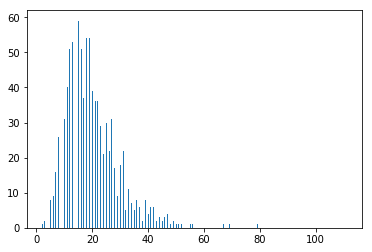

In [20]:
h_s = plt.hist(sents_per_docs_lengths, bins=500)

In [21]:
np.mean(sents_per_docs_lengths)

19.800000000000001

In [22]:
np.max(sents_per_docs_lengths)

111

In [23]:
np.std(sents_per_docs_lengths)

10.45303783595946

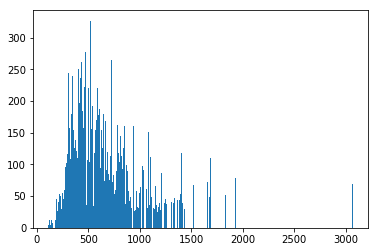

In [24]:
h_w = plt.hist(words_per_sents_lengths, bins=500)

In [25]:
np.mean(words_per_sents_lengths)

677.36979797979802

In [26]:
np.max(words_per_sents_lengths)

3067

In [27]:
np.std(words_per_sents_lengths)

361.23638615703925

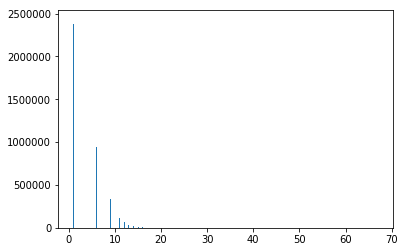

In [28]:
h_c = plt.hist(chars_per_words_lengths, bins=500)

In [29]:
np.mean(chars_per_words_lengths)

3.8788835783566293

In [30]:
np.max(chars_per_words_lengths)

67

In [31]:
np.std(chars_per_words_lengths)

2.5373921840645841

In [32]:
all_texts = list(all_texts.apply(BeautifulSoup).apply(BeautifulSoup.get_text).apply(clean_str))


/opt/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /opt/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [33]:
train_texts = list(data_train.review.apply(BeautifulSoup).apply(BeautifulSoup.get_text).apply(clean_str))
test_texts = list(data_test.review.apply(BeautifulSoup).apply(BeautifulSoup.get_text).apply(clean_str))

/opt/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /opt/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


## Build char vocab (all text)

In [34]:

vocab_to_int, int_to_vocab = build_chars_vocab(all_texts)
#np.savez('vocab_char-{}'.format(max_sent_len), vocab_to_int=vocab_to_int, int_to_vocab=int_to_vocab, max_sent_len=max_sent_len, min_sent_len=min_sent_len )
char2int = vocab_to_int
int2char = int_to_vocab

In [35]:
input_characters = sorted(list(vocab_to_int))
target_characters = sorted(list(vocab_to_int))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in all_texts])

In [36]:
print('Number of samples:', len(all_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)


Number of samples: 1000
Number of unique input tokens: 108
Number of unique output tokens: 108
Max sequence length for inputs: 13235


In [37]:
char2int

{'\t': 2,
 '\n': 3,
 ' ': 1,
 '!': 37,
 '#': 67,
 '$': 51,
 '%': 60,
 '&': 55,
 '(': 35,
 ')': 36,
 '*': 53,
 '+': 66,
 ',': 23,
 '-': 41,
 '.': 27,
 '/': 49,
 '0': 31,
 '1': 42,
 '2': 30,
 '3': 56,
 '4': 48,
 '5': 45,
 '6': 43,
 '7': 50,
 '8': 46,
 '9': 44,
 ':': 39,
 ';': 38,
 '<': 90,
 '=': 59,
 '>': 91,
 '?': 34,
 '@': 71,
 'UNK': 0,
 '[': 62,
 ']': 63,
 '^': 89,
 '_': 72,
 '`': 57,
 'a': 8,
 'b': 28,
 'c': 22,
 'd': 16,
 'e': 17,
 'f': 12,
 'g': 13,
 'h': 7,
 'i': 5,
 'j': 19,
 'k': 26,
 'l': 9,
 'm': 18,
 'n': 15,
 'o': 14,
 'p': 29,
 'q': 33,
 'r': 21,
 's': 10,
 't': 6,
 'u': 11,
 'v': 20,
 'w': 4,
 'x': 32,
 'y': 24,
 'z': 25,
 '{': 96,
 '|': 105,
 '}': 97,
 '~': 65,
 '\x84': 70,
 '\x85': 64,
 '\x91': 102,
 '\x96': 47,
 '\x97': 73,
 '¡': 93,
 '£': 52,
 '¨': 40,
 '®': 83,
 '´': 54,
 '·': 106,
 '½': 82,
 'à': 81,
 'á': 75,
 'â': 84,
 'ã': 98,
 'ä': 76,
 'æ': 92,
 'ç': 85,
 'è': 68,
 'é': 58,
 'ê': 61,
 'ï': 80,
 'ñ': 101,
 'ó': 69,
 'ô': 107,
 'ö': 86,
 'ø': 104,
 'ù': 87,
 'ü':

In [38]:
int2char

{0: 'UNK',
 1: ' ',
 2: '\t',
 3: '\n',
 4: 'w',
 5: 'i',
 6: 't',
 7: 'h',
 8: 'a',
 9: 'l',
 10: 's',
 11: 'u',
 12: 'f',
 13: 'g',
 14: 'o',
 15: 'n',
 16: 'd',
 17: 'e',
 18: 'm',
 19: 'j',
 20: 'v',
 21: 'r',
 22: 'c',
 23: ',',
 24: 'y',
 25: 'z',
 26: 'k',
 27: '.',
 28: 'b',
 29: 'p',
 30: '2',
 31: '0',
 32: 'x',
 33: 'q',
 34: '?',
 35: '(',
 36: ')',
 37: '!',
 38: ';',
 39: ':',
 40: '¨',
 41: '-',
 42: '1',
 43: '6',
 44: '9',
 45: '5',
 46: '8',
 47: '\x96',
 48: '4',
 49: '/',
 50: '7',
 51: '$',
 52: '£',
 53: '*',
 54: '´',
 55: '&',
 56: '3',
 57: '`',
 58: 'é',
 59: '=',
 60: '%',
 61: 'ê',
 62: '[',
 63: ']',
 64: '\x85',
 65: '~',
 66: '+',
 67: '#',
 68: 'è',
 69: 'ó',
 70: '\x84',
 71: '@',
 72: '_',
 73: '\x97',
 74: 'ı',
 75: 'á',
 76: 'ä',
 77: '’',
 78: '–',
 79: '‘',
 80: 'ï',
 81: 'à',
 82: '½',
 83: '®',
 84: 'â',
 85: 'ç',
 86: 'ö',
 87: 'ù',
 88: 'ü',
 89: '^',
 90: '<',
 91: '>',
 92: 'æ',
 93: '¡',
 94: '，',
 95: '、',
 96: '{',
 97: '}',
 98: 'ã',
 99:

In [39]:
len(int_to_vocab)

108

# Train review model

# Load documents data

In [40]:
'''
MAX_SENTS_PER_DOC = int(np.mean(sents_per_docs_lengths)) + 1
MAX_WORDS_PER_SENT = int(np.mean(words_per_sents_lengths)) + 1
MAX_CHARS_PER_WORD = int(np.mean(chars_per_words_lengths)) + 1
'''
MAX_SENTS_PER_DOC = 10
MAX_WORDS_PER_SENT = 40
MAX_CHARS_PER_WORD = 20
print('MAX_SENTS_PER_DOC = ' + str(MAX_SENTS_PER_DOC) + '\n')
print('MAX_WORDS_PER_SENT = ' + str(MAX_WORDS_PER_SENT) + '\n')
print('MAX_CHARS_PER_WORD = ' + str(MAX_CHARS_PER_WORD) + '\n')

NUM_CLASSES = 2

EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2

MAX_SENTS_PER_DOC = 10

MAX_WORDS_PER_SENT = 40

MAX_CHARS_PER_WORD = 20



# Vectorize documents data

In [41]:
train_input_data, train_targets = vectorize_sentences_data(input_texts=train_texts, 
                                                               target_labels=list(data_train.sentiment), 
                                                               max_sents_per_doc=MAX_SENTS_PER_DOC, 
                                                               max_words_per_sent=MAX_WORDS_PER_SENT, 
                                                               max_chars_per_word=MAX_CHARS_PER_WORD, 
                                                               num_classes=NUM_CLASSES, 
                                                               char2int=char2int)



In [42]:
test_input_data, _ = vectorize_sentences_data(input_texts=test_texts, 
                                               target_labels=None, 
                                               max_sents_per_doc=MAX_SENTS_PER_DOC, 
                                               max_words_per_sent=MAX_WORDS_PER_SENT, 
                                               max_chars_per_word=MAX_CHARS_PER_WORD, 
                                               num_classes=NUM_CLASSES, 
                                               char2int=char2int)

In [43]:
train_input_data.shape

(1000, 10, 40, 20)

In [44]:
len(train_input_data)

1000

In [45]:
train_targets.shape

(1000, 2)

In [46]:
test_input_data.shape

(1000, 10, 40, 20)

# Build model

In [47]:
char2word_latent_dim = 50
word2sent_latent_dim = 128
sent2doc_latent_dim = 128
char_vocab_size = len(char2int)

#MAX_SENTS_PER_DOC = 11
#MAX_WORDS_PER_SENT = 24
#MAX_CHARS_PER_WORD = 5
#_, _, _, encoder_word_embedding_model = build_chars2word_model(num_encoder_tokens=char_vocab_size, latent_dim=chars2word_latent_dim)
encoder_word_embedding_model = build_chars2word_model_simple_BiLSTM(num_encoder_tokens=char_vocab_size, latent_dim=char2word_latent_dim)
print(encoder_word_embedding_model.summary())
'''
_, _, _, encoder_sentence_embedding_model = build_words2sent_model(encoder_word_embedding_model, 
                                                                   max_words_seq_len=MAX_WORDS_PER_SENT, 
                                                                   max_char_seq_len=MAX_CHARS_PER_WORD,
                                                                   latent_dim=words2sent_latent_dim)
'''
encoder_sentence_embedding_model = build_words2sent_model_simple_BiLSTM(encoder_word_embedding_model, 
                                                                   max_words_seq_len=MAX_WORDS_PER_SENT, 
                                                                   max_char_seq_len=MAX_CHARS_PER_WORD, 
                                                                   latent_dim=word2sent_latent_dim)
print(encoder_sentence_embedding_model.summary())

encoder_document_embedding_model = build_sent2doc_model(encoder_sentence_embedding_model, 
                                                 max_sents_seq_len=MAX_SENTS_PER_DOC, 
                                                 max_words_seq_len=MAX_WORDS_PER_SENT, 
                                                 max_char_seq_len=MAX_CHARS_PER_WORD, 
                                                 word2sent_latent_dim=word2sent_latent_dim,
                                                 sent2doc_latent_dim=sent2doc_latent_dim)
print(encoder_document_embedding_model.summary())
model = build_hier_senti_model(encoder_document_embedding_model=encoder_document_embedding_model,
                                max_sents_seq_len=MAX_SENTS_PER_DOC, 
                                max_words_seq_len=MAX_WORDS_PER_SENT, 
                                max_char_seq_len=MAX_CHARS_PER_WORD)
print(model.summary())





/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("bi...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 108)         11664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               63600     
Total params: 75,264
Trainable params: 63,600
Non-trainable params: 11,664
_________________________________________________________________
None


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("la...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 40, 20)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 100)           75264     
_________________________________________________________________
bidirectional_2 (Bidirection [(None, 40, 256), (None,  234496    
_________________________________________________________________
lambda_1 (Lambda)            (None, 256)               0         
Total params: 309,760
Trainable params: 298,096
Non-trainable params: 11,664
_________________________________________________________________
None


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("la...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 10, 40, 20)   0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 40, 20)       0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 40, 20)       0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 40, 20)       0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_5 (

# Train model

In [48]:
batch_size = 64  # Batch size for training.
epochs = 1
lr = 0.01

model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_hier_senti_model-{}-{}.hdf5".format(MAX_SENTS_PER_DOC,MAX_WORDS_PER_SENT,MAX_CHARS_PER_WORD) # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]
model.fit(train_input_data, train_targets,
          #validation_data=(test_input_data, test_targets)
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          validation_split=0.2,
          shuffle=True)

Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 47s 59ms/step - loss: 0.0056 - categorical_accuracy: 0.5962 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000

Epoch 00001: val_categorical_accuracy improved from -inf to 1.00000, saving model to best_hier_senti_model-10-40.hdf5


# Test model

In [50]:
for i, rev in enumerate(test_texts):
    print(rev)
    sentiment = model.predict(np.expand_dims(test_input_data[i], 0))
    print('Sentiment: ' + str(sentiment))
    

naturally in a film whos main themes are of mortality, nostalgia, and loss of innocence it is perhaps not surprising that it is rated more highly by older viewers than younger ones. however there is a craftsmanship and completeness to the film which anyone can enjoy. the pace is steady and constant, the characters full and engaging, the relationships and interactions natural showing that you do not need floods of tears to show emotion, screams to show fear, shouting to show dispute or violence to show anger. naturally joyces short story lends the film a ready made structure as perfect as a polished diamond, but the small changes huston makes such as the inclusion of the poem fit in neatly. it is truly a masterpiece of tact, subtlety and overwhelming beauty.
Sentiment: [[ 0.50165802  0.49834198]]
this movie is a disaster within a disaster film. it is full of great action scenes, which are only meaningful if you throw away all sense of reality. lets see, word to the wise, lava burns you;

Sentiment: [[ 0.50165802  0.49834198]]
five medical students (kevin bacon, david labraccio; william baldwin, dr. joe hurley; oliver platt, randy steckle; julia roberts, dr. rachel mannus; kiefer sutherland, nelson) experiment with clandestine near death & afterlife experiences, (re)searching for medical & personal enlightenment. one by one, each medical students heart is stopped, then revived.under temporary death spells each experiences bizarre visions, including forgotten childhood memories. their flashbacks are like childrens nightmares. the revived students are disturbed by remembering regretful acts they had committed or had done against them. as they experience afterlife, they bring real life experiences back into the present. as they continue to experiment, their remembrances dramatically intensify; so much so, some are physically overcome. thus, they probe & transcend deeper into the death-afterlife experiences attempting to find a cure.even though the dvd was released in 2007,

Sentiment: [[ 0.50165802  0.49834198]]
im not really much of an abbott & costello fan (although i do enjoy whos on first) and, to be honest, there wasnt much in this movie that would inspire me to watch any more of their work. it wasnt really bad. it had some mildly amusing scenes, and actually a very convincing giant played by buddy baer, but somehow, given the fame of the duo and the esteem in which theyre generally held, i have to say i was expecting more. as the story goes, the pair stumble into a babysitting job, and during the reading of jack & the beanstalk as a bedtime story (with the kid reading it to costello), costellos jack falls asleep and dreams himself into the story. theres a wizard of oz kind of feel to the story, in that the characters in the dream are all the equivalents of real-life acquaintances of jack, and the movie opens in black & white and shifts to colour during the dream sequence. the fight scenes between jack and the giant and the dance scene between jack a

KeyboardInterrupt: 